# Stock Forecasting using PyFlux

### GASX models

https://github.com/RJT1990/pyflux

In [1]:
# Data manipulation
# ==============================================================================
import pandas as pd
import numpy as np
import datetime

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Modelling and Forecasting
# ==============================================================================
import pyflux as pf

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings("ignore")

# Yahoo finance is used to fetch data 
# ==============================================================================
import yfinance as yf
yf.pdr_override()

In [2]:
symbol = 'AMD' # input
market = '^GSPC'
start = '2020-01-01' # input 
end = '2022-07-18'  # input
df = yf.download(symbol, start, end)
df2 = yf.download(market, start, end)
one_mon = yf.download('^IRX', start, end)['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
log_returns = pd.DataFrame(np.diff(np.log(df['Adj Close'].values)))
log_returns.index = df.index.values[1:df.index.values.shape[0]]
log_returns.columns = [symbol + " Returns"]

log_returns.head()

,AMD Returns
2020-01-03,-0.010236
2020-01-06,-0.004330
2020-01-07,-0.002897
2020-01-08,-0.008743
2020-01-09,0.023555


In [4]:
market_returns = pd.DataFrame(np.diff(np.log(df2['Adj Close'].values)))
market_returns.index = df2.index.values[1:df2.index.values.shape[0]]
market_returns.columns = [market + " Returns"]

market_returns.head()

,^GSPC Returns
2020-01-03,-0.007085
2020-01-06,0.003527
2020-01-07,-0.002807
2020-01-08,0.004890
2020-01-09,0.006633


In [5]:
one_day = pd.DataFrame(np.log(1+one_mon)/365)
one_day.columns = ["US Treasury Returns"]
one_day

,US Treasury Returns
Date,
2020-01-02,0.002505
2020-01-03,0.002481
2020-01-06,0.002497
2020-01-07,0.002510
2020-01-08,0.002503
...,...
2022-07-12,0.003111
2022-07-13,0.003290
2022-07-14,0.003249


In [6]:
returns = pd.concat([one_day,log_returns,market_returns],axis=1).dropna()
returns.head()

,US Treasury Returns,AMD Returns,^GSPC Returns
2020-01-03,0.002481,-0.010236,-0.007085
2020-01-06,0.002497,-0.004330,0.003527
2020-01-07,0.002510,-0.002897,-0.002807
2020-01-08,0.002503,-0.008743,0.004890
2020-01-09,0.002510,0.023555,0.006633


In [7]:
excess_stock = returns["AMD Returns"].values - returns['US Treasury Returns'].values
excess_market = returns["^GSPC Returns"].values - returns['US Treasury Returns'].values

In [8]:
final_returns = pd.DataFrame(np.transpose([excess_stock,excess_market, returns['US Treasury Returns'].values]))
final_returns.columns=["AMD","SP500","Rf"]
final_returns.index = returns.index

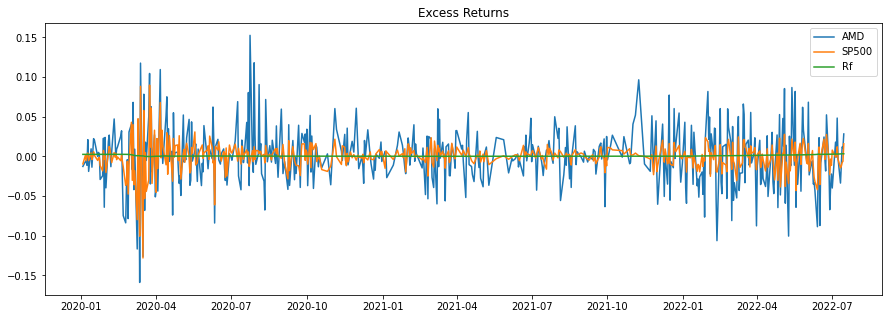

In [9]:
plt.figure(figsize=(15,5))
plt.title("Excess Returns")
x = plt.plot(final_returns);
plt.legend(iter(x), final_returns.columns)

In [10]:
model = pf.GASX(formula="AMD ~ SP500",data=final_returns,ar=1,sc=1,family=pf.t())
x = model.fit()
x.summary()

t GAS X(1,0,1)                                                                                            
======================================================= ==================================================
Dependent Variable: AMD                                 Method: MLE                                       
Start Date: 2020-01-06 00:00:00                         Log Likelihood: 1145.619                          
End Date: 2022-07-15 00:00:00                           AIC: -2279.238                                    
Number of observations: 516                             BIC: -2253.7613                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    -0.0682    0.0278     -2.4538  0.0141   (-0.1226 | -0.0137)      
SC(1)                                

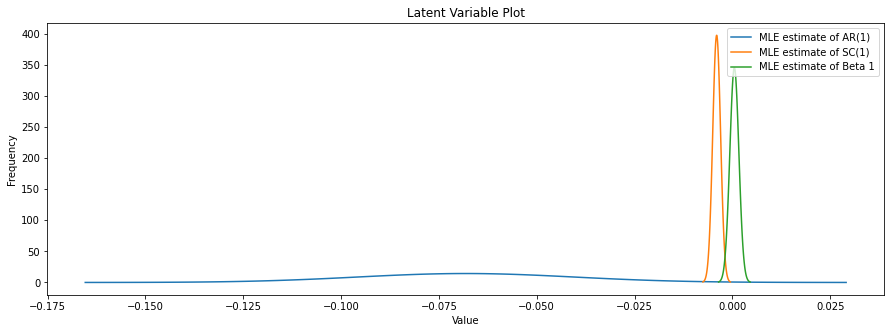

In [11]:
model.plot_z(indices=[0,1,2])

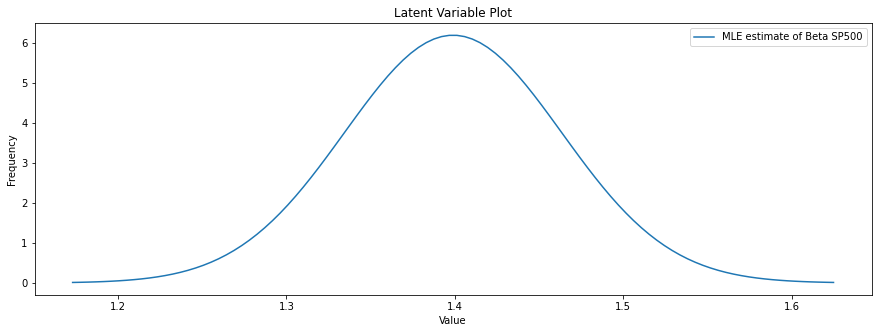

In [12]:
model.plot_z(indices=[3])

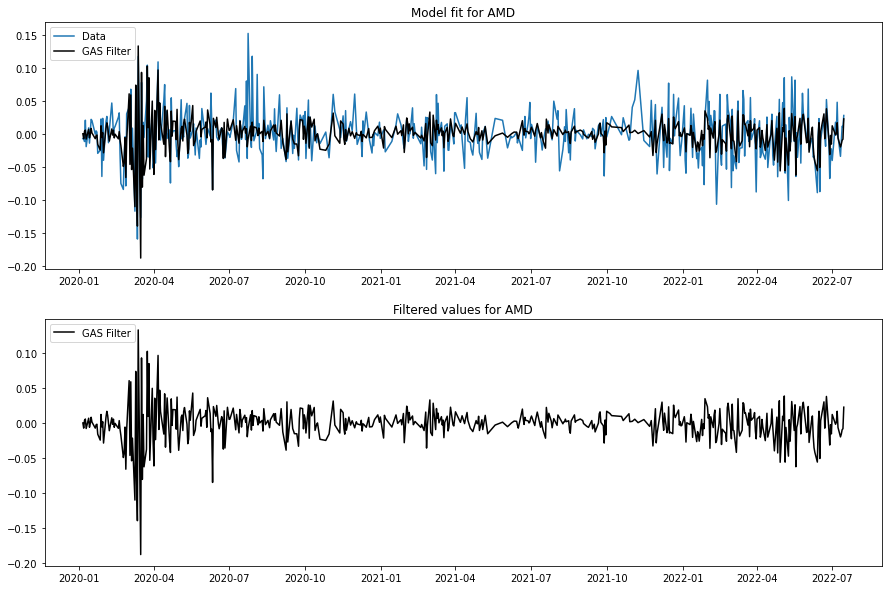

In [13]:
model.plot_fit(figsize=(15,10))